In [1]:
from bloch.utils import *
from bloch.epg_transforms import *

import autograd.numpy as np

import tensorflow as tf

import time as time


%load_ext autoreload
%autoreload 2
%matplotlib notebook

import matplotlib.pyplot as plt # import after calling magic or run this cell twice

do_S0_T2_jointly = False

/home/pkllee/anaconda2/envs/tf3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def make_spin_echo_t2_graph(do_log=False, N_echos=1, do_S0_T2_jointly=False):
    
    t2_graph = tf.Graph()
    
    with t2_graph.as_default():
        
        # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5240500/
        T1_myocardium = tf.constant(1052.) # ms at 3T
        T2_myocardium = tf.constant(45.)
        
        T1, T2_var = (tf.constant(1000.), tf.Variable(80., name='T2')) # ms
        
        TE_var = tf.Variable(10., name='TE') # ms
        M0_var = tf.Variable(1., name='M0')
        FZ_init = tf_get_FZ_init(M0_var)
        
        alpha = 90.
        phi = 90.
        
        fim = 0.                
        
        def tf_concat_echos(echos, FZ_echo):
            with tf.name_scope('concat_echo') as scope:
                echo = tf.expand_dims(tf.real(tf_FZ0_to_M(FZ_echo))[:, 0], 1) # to make same size as M_echos
                if(echos == None):
                    echos = echo
                else:
                    echos = tf.concat((echos, echo), axis=1)                
            return echos, echo
        
        with tf.name_scope('bloch_operator_setup'):
            f_rf_alpha = tf_get_rf_epg(alpha, phi)
            f_inversion = tf_get_rf_epg(180., phi)
            
            f_relax_TE = tf_get_relax_epg(M0_var, TE_var, T1, T2_var)
        
        with tf.name_scope('multi_spin_echo'):                  
            
            def get_fim_at_echo(_M_echo):
                # tf gradients returns a list, use index 0 of echo since that is x component
                del_M_ii_del_T2 = tf.abs(tf.gradients(_M_echo[0, 0], T2_var, name='dM_dtiss_param')[0])
                del_M_ii_del_M0 = tf.abs(tf.gradients(_M_echo[0, 0], M0_var, name='dM_dtiss_param')[0])
                
                if(do_S0_T2_jointly):
                    return tf.convert_to_tensor([[del_M_ii_del_M0 * del_M_ii_del_M0, del_M_ii_del_M0 * del_M_ii_del_T2], \
                                             [del_M_ii_del_M0 * del_M_ii_del_T2, del_M_ii_del_T2 * del_M_ii_del_T2]])                    
                else:
                    return del_M_ii_del_T2 * del_M_ii_del_T2                    
                        
            FZ_excited = f_rf_alpha(FZ_init)
            
            FZ_echo_1 = f_relax_TE(FZ_excited)
                        
            M_echos, M_echo = tf_concat_echos(None, FZ_echo_1)                                
            fim = fim + get_fim_at_echo(M_echo)
            
            FZ_echo_in = FZ_echo_1
            
            for ii in range(0, N_echos - 1): # subtract 1 since already got first echo
                FZ_echo = f_relax_TE(FZ_echo_in) # assume perfect refocusing
                
                M_echos, M_echo = tf_concat_echos(M_echos, FZ_echo)
                fim = fim + get_fim_at_echo(M_echo)
                
                FZ_echo_in = FZ_echo
                
            if(do_S0_T2_jointly):
                #fim_det = fim[0, 0] * fim[1, 1] - fim[0, 1] * fim[1, 0]
                #V = tf.convert_to_tensor([[fim[1, 1], -fim[1, 0]], [-fim[0, 1], fim[0, 0]]])
                V = tf.matrix_inverse(fim)
                crb = V[1, 1] # pop out the T2 CRLB                
            else:
                V = 1 / fim
                crb = V                

                
                 
        t2_graph_session = tf.Session()
        if(do_log):
            tf.summary.FileWriter('./tmp/', t2_graph)    
        
        def run_spin_echo_t2_tf_graph(T2_in, TE_in, tensors_to_eval):
            t2_assign_op = T2_var.assign(T2_in)
            te_assign_op = TE_var.assign(TE_in)
            M0_assign_op = M0_var.assign(1.)

            with t2_graph.as_default():
                t2_graph_session.run(t2_assign_op)
                t2_graph_session.run(te_assign_op)
                t2_graph_session.run(M0_assign_op)
                out = t2_graph_session.run(tensors_to_eval)

            return out
        
        def crb_obj(T2_in, TE_in):      
            tensors_to_eval = [M_echos, crb, fim]            
            M_echos_eval, crb_eval, fim_eval = run_spin_echo_t2_tf_graph(T2_in, TE_in, tensors_to_eval)
            
            return M_echos_eval, crb_eval, fim_eval
        
        def crb_debug(T2_in, TE_in):
            tensors_to_eval = [fim]
            fim_eval = run_spin_echo_t2_tf_graph(T2_in, TE_in, tensors_to_eval)
            return fim_eval
        
    return crb_obj, crb_debug


# Test 1 echo case

In [3]:
crb_obj, _ = make_spin_echo_t2_graph(N_echos=1, do_S0_T2_jointly=False)

In [4]:
crb_eval_list = []
crb_theo_list = []
t2_list = np.linspace(5., 150., 50.)

TE = 20.
analytical_crb = lambda x: np.square(1 / (TE * np.exp(-TE/x)/(np.square(x))))

for _t2 in t2_list:
    _, crb_eval, _ = crb_obj(_t2, TE)
    crb_eval_list.append(crb_eval)
    crb_theo_list.append(analytical_crb(_t2))
    
    
crb_theo_list = np.array(crb_theo_list) * np.amax(np.array(crb_eval_list)) / np.amax(np.array(crb_theo_list))

<IPython.core.display.Javascript object>


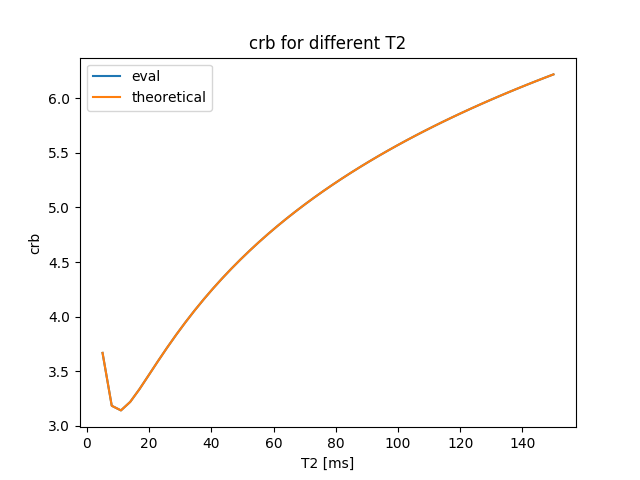

In [5]:
plt.figure()
plt.plot(t2_list, np.log10(crb_eval_list))
plt.plot(t2_list, np.log10(crb_theo_list ))
plt.xlabel('T2 [ms]')
plt.ylabel('crb')
plt.legend(['eval', 'theoretical'])
plt.title('crb for different T2')
plt.show()

## Test multi echo case

In [6]:
crb_obj, _ = make_spin_echo_t2_graph(do_log=True, N_echos=8)

<IPython.core.display.Javascript object>


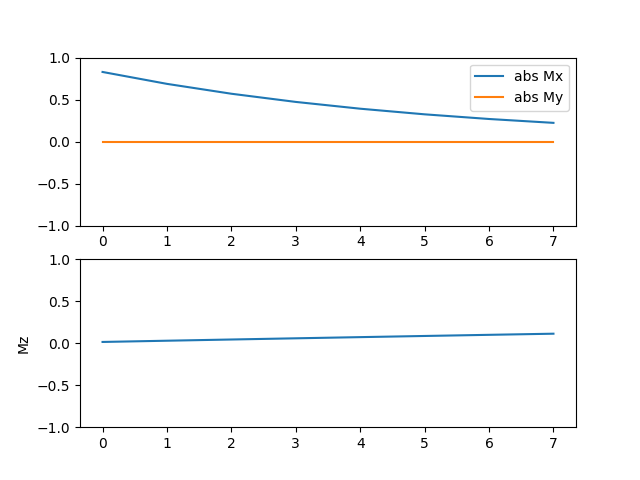

In [7]:
TE = 15.
M_echos_eval, _, fim_eval = crb_obj(80., TE)

# M_echos should be a 3xN np array
def plot_echos(M_echos, title=''):
    
    def plot_train(_y, _y_label=''):
        plt.plot(_y)
        plt.ylim([-1, 1])
        plt.ylabel(_y_label)
    
    plt.figure()
    plt.subplot(211)    
    plot_train(abs(M_echos[0, :]))
    plot_train(abs(M_echos[1, :]))
    plt.title(title)
    plt.legend(['abs Mx', 'abs My'])
    plt.subplot(212)
    plot_train(M_echos[2, :], 'Mz')
    
    plt.show()
    

plot_echos(M_echos_eval)

In [8]:
t2_list = np.linspace(2., 100., 80.)
TE_of_interest = 20.
t2_over_te = t2_list / TE_of_interest


colours = ['C0','C1', 'C2', 'C3', 'C4', 'C5']
linestyles = ['dashed', 'solid', 'dashed', 'dashed', 'dashed', 'dashed']

if(do_S0_T2_jointly):
    echos_to_plot = range(2, 7)
    colours = colours[1:6]
    linestyles = linestyles[1:6]
else:
    echos_to_plot = range(1, 7)

def get_crb_for_fixed_TE(N_echos):
    crb_obj, _ = make_spin_echo_t2_graph(N_echos=N_echos, do_S0_T2_jointly=do_S0_T2_jointly)
    crb_eval_list = []

    for _t2 in t2_list:
        _, crb_eval, fim_eval = crb_obj(_t2, TE_of_interest)
        crb_eval_list.append(crb_eval)
        
    return np.array(crb_eval_list)[:, np.newaxis]

for ii in echos_to_plot:
    crb_eval_list = get_crb_for_fixed_TE(N_echos=ii)
    
    if(ii == echos_to_plot[0]):
        crb_eval_arr_vary_t2 = crb_eval_list
    else:
        crb_eval_arr_vary_t2 = np.concatenate((crb_eval_arr_vary_t2, crb_eval_list), axis=1)

<IPython.core.display.Javascript object>


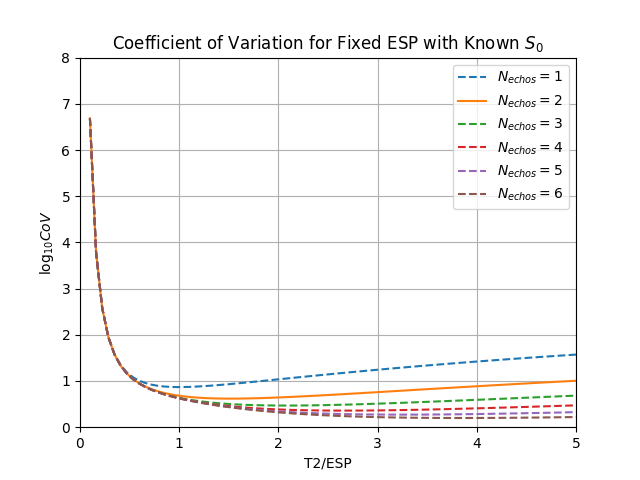

In [9]:
plt.figure()
coeff_of_var = crb_eval_arr_vary_t2 / np.square(t2_list[:, np.newaxis])

for ii, _ in enumerate(echos_to_plot):
    plt.plot(t2_over_te, np.log10(coeff_of_var[:, ii]), color=colours[ii], ls=linestyles[ii])
    
plt.xlabel('T2/ESP')
plt.ylabel(r'$\log_{10} CoV$')
plt.xlim([0, np.amax(t2_over_te)])
#plt.ylim([0, np.max(np.log10(coeff_of_var))])
plt.ylim([0, 8])
plt.legend([r'$N_{echos} = ' + str(i) + '$' for i in echos_to_plot])

if(do_S0_T2_jointly):
    plt.title(r'Coefficient of Variation for Fixed ESP with Unknown $S_0$')
else:
    plt.title(r'Coefficient of Variation for Fixed ESP with Known $S_0$')
plt.grid(True)
plt.show()

## Change TE for a fixed T2

In [10]:
T2_of_interest = 80. # ms
te_list = np.linspace(5., 160., 80)
te_over_t2_list = te_list / T2_of_interest

def get_crb_for_fixed_T2(N_echos):
    crb_obj, _ = make_spin_echo_t2_graph(N_echos=N_echos, do_S0_T2_jointly=do_S0_T2_jointly)
    crb_eval_list = []

    for _te in te_list:
        _, crb_eval, _ = crb_obj(T2_of_interest, _te)
        crb_eval_list.append(crb_eval)
        
    return np.array(crb_eval_list)[:, np.newaxis]

start = time.time()
for ii in echos_to_plot:
    crb_eval_list = get_crb_for_fixed_T2(N_echos=ii)
    
    if(ii == echos_to_plot[0]):
        crb_eval_arr_vary_te = crb_eval_list
    else:
        crb_eval_arr_vary_te = np.concatenate((crb_eval_arr_vary_te, crb_eval_list), axis=1)
        
    best_echo_time = te_list[np.argmin(crb_eval_list)]
    print(best_echo_time * (np.arange(0, ii) + 1))

print('elapsed time: ' + str(time.time() - start))

[79.55696203]
[ 52.08860759 104.17721519]
[ 38.35443038  76.70886076 115.06329114]
[ 30.50632911  61.01265823  91.51898734 122.02531646]
[ 24.62025316  49.24050633  73.86075949  98.48101266 123.10126582]
[ 20.69620253  41.39240506  62.08860759  82.78481013 103.48101266
 124.17721519]
elapsed time: 32.53869581222534


<IPython.core.display.Javascript object>


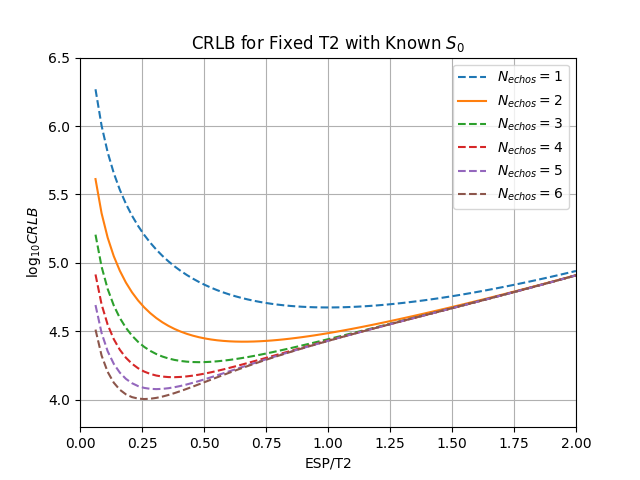

In [11]:
plt.figure()

for ii, _ in enumerate(echos_to_plot):
    plt.plot(te_over_t2_list, np.log10(crb_eval_arr_vary_te[:, ii]), color=colours[ii], ls=linestyles[ii])
    
plt.xlabel('ESP/T2')
plt.ylabel(r'$\log_{10} CRLB$')
plt.xlim([0, max(te_over_t2_list)])

if(do_S0_T2_jointly):
    plt.title(r'CRLB for Fixed T2 with Unknown $S_0$')
else:
    plt.title(r'CRLB for Fixed T2 with Known $S_0$')

plt.ylim([3.8, 6.5])
plt.legend([r'$N_{echos} = ' + str(i) + '$' for i in echos_to_plot])
plt.grid(True)
plt.show()